# Spectral Imagery Field Binary Classification

  This program takes in spectral imagery of corn fields and soybean fields and performs a binary classification on the data.

## Specifications:
  * Conducts a binary classification
  * Linearly transforms the data
  * Uses the SGD for optimization

## Input:
  * Images are of corn and soybean fields
  * 1140 tif images of SENTIEL2 spectral imagery (Bands: Green, Red, and Near InfraRed)
  * Band Order: NIR, Red, Green
  * 610 are images of corn fields
  * 530 are images of soybean fields


## Analysis:
  * Splits the data into an 80/20 for learning and testing

## Results:
  * Obtains roughly a 92% accuracy of determining the type of field

# Data Used:

  * The data used was SENTINEL2 (Bands: Green, Red, and Near Infrared) taken on July 13th, 2023
  * I created the individual images by collecting Sentinel2 imagery and using
  crop field boundaries (USDA Crop Sequence Boundaries) to create 1140 images in ArcGIS Pro.


## Other Strategies:

  1. Used only the Red and NIR bands to create a dataset that has the simple vegetation index, which resulted in roughly 91% accuracy

  2. Used ADAM got 88% accuracy

In [ ]:
# The data was created from taking the spectral imagery (SENTINEL2 satelite imagery) of corn and soybean fields in Sangamon County in Illinois  and creating 1140 independent images of those fields based on the Illinois field boundary polygon feature layer (located here:    )
#   Images 1 - 610:       Exclusively corn field imagery
#   Images 611 - 1140:    Exclusively soy-bean field imagery

# Installs and Imports

We need to first install torchgeo, which gives us several tools for manupulating raster images.

After torchgeo is installed, you will need to restart the session to use it

More info about torchgeo can be found on their website at https://www.osgeo.org/projects/torchgeo/


In [1]:
%pip install torchgeo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.5/454.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.3/833.3 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.5/808.5 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 30.5 MB/s eta 

In [1]:
import os
import rasterio
import torch
import torchvision
from PIL import Image
from torchvision import transforms

In [2]:
# from google.colab import drive
# drive.mount('/drive')

In [3]:
# Import torch and set the manual seed to remove randomness
import torch

torch.manual_seed(42)
device = 'cpu'

# Resizing Images

* The data used for this is spectral imagery (3 Bands: Green, Red, and Near Infra-Red) stored in .tif files and have varying sizes.
* To create a dataloader and input this spectral imagery into a model for training and testing, it needs to be uniform.
* I firstly convert the iageery into a tensor in order to be able to manipulate it
* I resized the images to 32 x 32 resolution since the majority of images were slightly larger than that number (I also tried 48 x 48, but the results were slighly less accurate)
* Lastly, I store all of these tensors into an array

In [19]:
import os
import rasterio
import torch
import torchvision
from PIL import Image
from torchvision import transforms

# Function to resize and save images into an array
def resize_images(source_folder, size=(32, 32)):
    if not os.path.exists(source_folder):
        # os.makedirs(source_folder)
        print("Path not exists")

    # # Define the transformation to resize the images
    # transform = transforms.Compose([
    #     transforms.Resize(size),
    #     transforms.ToTensor()
    # ])

    arrays = []

    for filename in os.listdir(source_folder):
        if filename.endswith(".tif"):  # You can add more extensions if needed
            img_path = os.path.join(source_folder, filename)
            with rasterio.open(img_path) as src:

              data = src.read()
              # Apply the transformation

              # print(type(data))
              # print(data.shape)
              data = torch.Tensor(data)
              data = torchvision.transforms.functional.resize(data, (32, 32), interpolation=2)
              # print(data.shape)
              arrays.append(data)

    return arrays


# Define your source folder where the raw spectral imagery is (Folder provided on Github: https://github.com/Brandon-7-Sharp/Spectral-Imagery-Field-Binary-Classification)
source_folder = f"/content/drive/MyDrive/Colab Notebooks/Raster_Field_Data"

# Call the function to resize and save images
data = resize_images(source_folder)
print(len(data))

1140


#### This was the resizing images function that used the Red and NIR bands to create arrays of the Normal Vegetative Index

In [5]:
# # Function to resize and save images
# def resize_images(source_folder, size=(32, 32)):
#     if not os.path.exists(target_folder):
#         os.makedirs(target_folder)
#         print("Path not exists")

#     # Define the transformation to resize the images
#     transform = transforms.Compose([
#         transforms.Resize(size),
#         transforms.ToTensor()
#     ])

#     arrays_1 = []

#     for filename in os.listdir(source_folder):
#         if filename.endswith(".tif"):  # You can add more extensions if needed
#             img_path = os.path.join(source_folder, filename)
#             with rasterio.open(img_path) as src:

#               data = src.read()
#               # Apply the transformation

#               # print(type(data))
#               # print(data.shape)
#               data = torch.Tensor(data)
#               data = torchvision.transforms.functional.resize(data, (32, 32), interpolation=2)
#               data = data[:2] # Removes the Green Band


#               data = data[1] / data[0]  # Calculates the Simple Vegetation Index by dividing the NIR band by the Red band
#                                         # This results in a (32, 32) sized Tensor

#               data = torch.nan_to_num(data, nan=0.0)


#               # print(data.shape)
#               # print(data)
#               arrays_1.append(data)

#     return arrays_1


# # Define your source and target folders
# source_folder = f"/content/drive/MyDrive/Colab Notebooks/Raster_Field_Data"
# target_folder = f"/content/drive/MyDrive/Colab Notebooks/Raster_Field_Data"

# # Call the function to resize and save images
# data = resize_images(source_folder)
# # print(len(data))

## Dataset Class: RasterImageryDataset

* Creates a function for returning the length of the datset
* Creates a function for returning a specific index of the dataset and the label for it

In [31]:
from torch.utils.data import Dataset


# Custom Dataset class that takes in an array of tensors (of spectral imagery) and their labels (corn field or soy-bean field)

class RasterImageryDataset(Dataset):
  def __init__(self, data, labels):
    self.labels = labels
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return(self.data[idx], self.labels[idx])

# Labels

* Creates a labels array Of the 1140 images
  * Images 1 - 610:       Exclusively corn field imagery
  * Images 611 - 1140:    Exclusively soy-bean field imagery

In [32]:
import numpy as np
import random


# Creates a labels array
#   Of the 1140 images
#     Images 1 - 610:       Exclusively corn field imagery
#     Images 611 - 1140:    Exclusively soy-bean field imagery
corn_lables = np.zeros(610)
wheat_labels = np.zeros(530)
labels = np.append(corn_lables, wheat_labels)

test_data = []
train_data = []
test_labels = []
train_labels = []

for i, value in enumerate(data):
  if i < 610:
    if i < 122:
      test_data.append(data[i])
      test_labels.append(0)
    else:
      train_data.append(data[i])
      train_labels.append(0)
  else:
    if i < 716:
      test_data.append(data[i])
      test_labels.append(1)
    else:
      train_data.append(data[i])
      train_labels.append(1)


# Creates a dataset variable with the images and their labels
dataset = RasterImageryDataset(data=data, labels=labels)

# Datasets and Dataloaders

In [33]:
# Creates two seperate datasets with no overlapping data (One for training and another for testing. 80/20 Split)
train_dataset = RasterImageryDataset(train_data, train_labels)
test_dataset = RasterImageryDataset(test_data, test_labels)

In [34]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterabels (batches)
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c174fed7fd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7c174fed7bb0>)

# Model Class: Sentinel2ModelV0

In [35]:
from torch import nn

# Create a model class that takes in the input shape of the data, the hidden units of the data, and the output shape of the data
class Sentinel2ModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),  # Non-Linear Function
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()  # Non-Linear Function
    )

  def forward(self, x):
    return self.layer_stack(x)

In [36]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = Sentinel2ModelV0(
    # input_shape=1024, # This is 32 x 32 (pixel width and height of the resized raster images)
    input_shape=3072, # This is 32 x 32 (pixel width and height of the resized raster images)
    hidden_units=3, # How many units in the hidden layer
    output_shape=81 # One for every class

).to(device)

model_0

Sentinel2ModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=3, bias=True)
    (2): ReLU()
    (3): Linear(in_features=3, out_features=81, bias=True)
    (4): ReLU()
  )
)

In [37]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_fuunctions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [38]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

# Training and Testing

In [43]:
# Import tqdm for progress bar
from timeit import default_timer as timer
from tqdm.auto import tqdm

# Set the start timer
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 100

# Create train loss, test loss, and accuracy arrays
train_loss_array = []
test_loss_array = []
accuracy_array = []

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  ### Training
  train_loss = 0
  # Add a looop to loop through the training batches
  for batch, (X, y) in enumerate(train_dataloader): # -> (image, label)
    model_0.train()
    # 1. Forward Pass
    y_pred = model_0(X)
    y = torch.tensor(y, dtype=torch.long, device=device)

    # 2. Calculate Loss (Per Batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # Accumulate train loss

    # 3. Optimizer Zero Grad
    optimizer.zero_grad()

    # 4. Loss Backward
    loss.backward()

    # 5. Optimizer Step
    optimizer.step()

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # 1. Forward Pass
      test_pred = model_0(X_test)
      y_test = torch.tensor(y_test, dtype=torch.long, device=device)

      # 2. Calculate Loss (accumulatively)
      test_loss += loss_fn(test_pred, y_test)

      # 3. Calculate Accuracy
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    # Calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # Calculate the test accuracy average per batch
    test_acc /= len(test_dataloader)

  # Print out what is happening
  print(f"\nTrain loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
  train_loss_array.append(train_loss)
  test_loss_array.append(test_loss)
  accuracy_array.append(test_acc)
  epoch_array = np.arange(0, epochs)





  # plt.plot(epoch_array, train_loss_array)
  # plt.plot(epoch_array, test_loss_array)
  # plt.plot(epoch_array, accuracy_array)
  # plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
------

Train loss: 4.4127 | Test Loss: 4.4123, Test Accuracy: 0.0000
Epoch: 1
------

Train loss: 4.4117 | Test Loss: 4.4115, Test Accuracy: 0.0000
Epoch: 2
------

Train loss: 4.4110 | Test Loss: 4.4106, Test Accuracy: 0.0000
Epoch: 3
------

Train loss: 4.4100 | Test Loss: 4.4097, Test Accuracy: 0.0000
Epoch: 4
------


<ipython-input-43-054edcdc0907>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long, device=device)
<ipython-input-43-054edcdc0907>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long, device=device)



Train loss: 4.4092 | Test Loss: 4.4089, Test Accuracy: 0.0000
Epoch: 5
------

Train loss: 4.4084 | Test Loss: 4.4088, Test Accuracy: 0.0000
Epoch: 6
------

Train loss: 4.4075 | Test Loss: 4.4072, Test Accuracy: 0.0000
Epoch: 7
------

Train loss: 4.4067 | Test Loss: 4.4069, Test Accuracy: 0.0000
Epoch: 8
------

Train loss: 4.4061 | Test Loss: 4.4080, Test Accuracy: 0.0000
Epoch: 9
------

Train loss: 4.4064 | Test Loss: 4.4057, Test Accuracy: 0.0000
Epoch: 10
------

Train loss: 4.4043 | Test Loss: 4.4045, Test Accuracy: 0.0000
Epoch: 11
------

Train loss: 4.4040 | Test Loss: 4.4035, Test Accuracy: 0.0000
Epoch: 12
------

Train loss: 4.4032 | Test Loss: 4.4038, Test Accuracy: 0.0000
Epoch: 13
------

Train loss: 4.4027 | Test Loss: 4.4032, Test Accuracy: 0.0000
Epoch: 14
------

Train loss: 3.1290 | Test Loss: 1.0429, Test Accuracy: 52.3438
Epoch: 15
------

Train loss: 0.8131 | Test Loss: 0.8532, Test Accuracy: 47.6562
Epoch: 16
------

Train loss: 0.7324 | Test Loss: 0.7905, Te

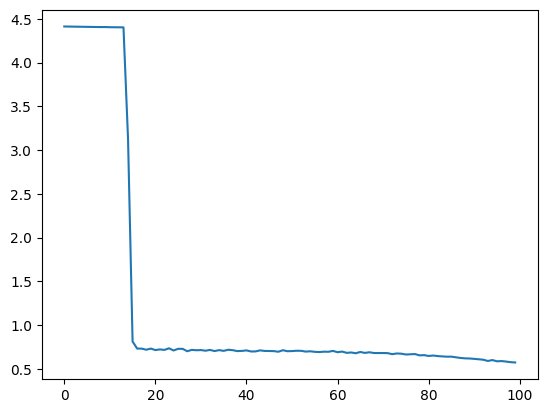

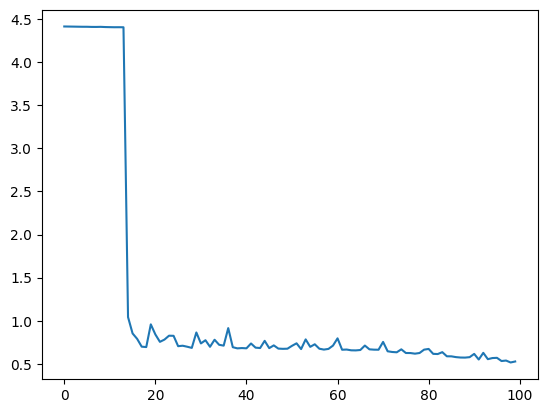

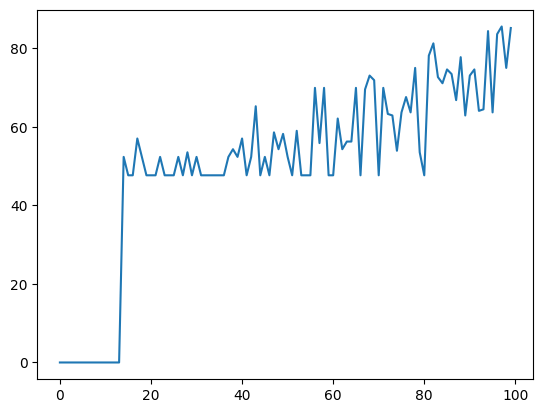

In [44]:
import matplotlib.pyplot as plt
new_train_loss_array = []

for element in train_loss_array:
  new_train_loss_array.append(element.detach().numpy())

plt.plot(epoch_array, new_train_loss_array)
plt.show()
plt.plot(epoch_array, test_loss_array)
plt.show()
plt.plot(epoch_array, accuracy_array)
plt.show()

In [41]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      # Make Predictions
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # Only works when model was created with a unique name
          "model_loss": loss.item(),
          "model_acc": acc}

# Calculate model results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

{'model_name': 'Sentinel2ModelV0',
 'model_loss': 4.4134931564331055,
 'model_acc': 0.0}

In [42]:
# Display the train loss, test loss, and accuracy arrays